In [2]:
import collections
import os
import re
import subprocess

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.optim import AdamW
from torch.utils.data import DataLoader

from tqdm.auto import tqdm

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import get_polynomial_decay_schedule_with_warmup

from peft import get_peft_model, LoraConfig, TaskType

from torchmetrics.functional import accuracy

from IPython.display import clear_output

# Конфигурация
sns.set_style('darkgrid')
os.environ['TOKENIZERS_PARALLELISM'] = 'false'



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
df_train = pd.read_csv('/kaggle/input/newnew-pt1c4/df1_train.csv')
df_test = pd.read_csv('/kaggle/input/newnew-pt1c4/df1_test.csv')



In [5]:
df_train.columns = ['lemmatized_text', 'Class']
df_test.columns = ['lemmatized_text', 'Class']
df_train.columns

Index(['lemmatized_text', 'Class'], dtype='object')

In [6]:
df_train['lemmatized_text'][1]

'ыыыыыыыыыыыы\n\nЛондон хочет, чтобы Москва выдала подозреваемых по делу Скрипалей, заявил британский премьер.В не лемматизированном тексте 94 символа . В не лемматизированном тексте 11 уникальных слов . Самая распрастраненная часть речи PROPN . В изначальном тексте 2 стоп слов . В изначальном тексте 13 уникальных слов . '

In [7]:
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    PUNCT_TO_REMOVE = '&*+/<=>^_`{|}~'
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

def remove_multiple_spaces(text):
    result = re.sub(' +', ' ', text)
    return result



In [8]:
df_train['lemmatized_text'] = df_train['lemmatized_text'].apply(lambda text: remove_punctuation(text))
df_test['lemmatized_text'] = df_test['lemmatized_text'].apply(lambda text: remove_punctuation(text))

df_train['lemmatized_text'] = df_train['lemmatized_text'].apply(lambda text: remove_multiple_spaces(text))
df_test['lemmatized_text'] = df_test['lemmatized_text'].apply(lambda text: remove_multiple_spaces(text))

In [9]:
model_checkpoint = 'ai-forever/rugpt3small_based_on_gpt2'


tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})



tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

1

In [10]:
class Model(nn.Module):
    def __init__(self, tokenizer, num_classes=2):
        super().__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_classes)
        self.model.resize_token_embeddings(len(tokenizer))
        self.config = self.model.config

    def forward(self, input_ids=None, attention_mask=None, inputs_embeds=None, *args, **kwargs):
        out = self.model.transformer(
            input_ids=input_ids, inputs_embeds=inputs_embeds, attention_mask=attention_mask
        ).last_hidden_state
        lens = attention_mask.sum(-1).cpu() - 1
        out = out[torch.arange(len(lens)), lens.to(torch.long)]
        
        return self.model.score(out)
    
    @property
    def device(self):
        return next(self.model.parameters()).device


num_classes = 2
model = Model(tokenizer, num_classes)

config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/551M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at ai-forever/rugpt3small_based_on_gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
model

Model(
  (model): GPT2ForSequenceClassification(
    (transformer): GPT2Model(
      (wte): Embedding(50258, 768)
      (wpe): Embedding(2048, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D()
            (c_proj): Conv1D()
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (score): Linear(in_features=768, out_features=2, bias=False)
  )
)

In [12]:
sum([p.numel() for p in model.parameters()])

125228544

In [13]:
tokenizer(df_train['lemmatized_text'].iloc[1])

{'input_ids': [276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 203, 203, 1098, 18920, 3957, 16, 753, 5343, 48310, 30650, 334, 6619, 48083, 10283, 16, 2815, 33256, 7638, 18, 677, 322, 359, 339, 20892, 848, 22439, 16152, 31932, 6492, 264, 1492, 365, 322, 359, 339, 20892, 848, 22439, 16152, 2287, 39760, 1280, 1492, 26605, 1039, 287, 1663, 3626, 2301, 8180, 23568, 42212, 50, 1492, 365, 33110, 4357, 16152, 491, 12610, 1280, 1492, 365, 33110, 4357, 16152, 2511, 39760, 1280, 1492, 225], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [14]:
df_train['lemmatized_text'].iloc[1]

'ыыыыыыыыыыыы\n\nЛондон хочет, чтобы Москва выдала подозреваемых по делу Скрипалей, заявил британский премьер.В не лемматизированном тексте 94 символа . В не лемматизированном тексте 11 уникальных слов . Самая распрастраненная часть речи PROPN . В изначальном тексте 2 стоп слов . В изначальном тексте 13 уникальных слов . '

In [15]:
df_train['len'] = df_train['lemmatized_text'].apply(len)
df_train = df_train[df_train['len']<=375]

df_test['len'] = df_test['lemmatized_text'].apply(len)
df_test = df_test[df_test['len']<=375]

In [16]:
df_test

,lemmatized_text,Class,len
0,Постановлением губернатора Дмитрия Азарова в р...,0,350
1,В российский прокат выходит второй сезон сериа...,1,343
2,При этом общие мощности Группы по выпуску пелл...,0,322
3,"Здесь ведь не Петербург: ни пожарной команды, ...",1,280
4,Топили баню мылась Настя с Фаей играли спать в...,0,273
...,...,...,...
12890,Свобода несет ответственность за нарушения в с...,1,267
12892,Ажнина Мария Семенова Анна Иванова Мария М. Ю....,0,269
12893,Могу ли я сфотографировать вас?В не лемматизир...,1,241
12894,"Гэмбон, наряду с Робертом Стивенсом, Дереком Я...",0,355


In [17]:
tokenizer.decode([276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 203, 203, 1098, 18920, 3957, 16, 753, 5343, 48310, 30650, 334, 6619, 48083, 10283, 16, 2815, 33256, 7638, 18, 677, 322, 359, 339, 20892, 848, 22439, 16152, 31932, 6492, 264, 1492, 365, 322, 359, 339, 20892, 848, 22439, 16152, 2287, 39760, 1280, 1492, 26605, 1039, 287, 1663, 3626, 2301, 8180, 23568, 42212, 50, 1492, 365, 33110, 4357, 16152, 491, 12610, 1280, 1492, 365, 33110, 4357, 16152, 2511, 39760, 1280, 1492, 225])

2024-02-20 06:27:56.636905: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 06:27:56.637035: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 06:27:56.760594: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


'ыыыыыыыыыыыы\n\nЛондон хочет, чтобы Москва выдала подозреваемых по делу Скрипалей, заявил британский премьер.В не лемматизированном тексте 94 символа. В не лемматизированном тексте 11 уникальных слов. Самая распрастраненная часть речи PROPN. В изначальном тексте 2 стоп слов. В изначальном тексте 13 уникальных слов. '

In [18]:
batch_size = 50
train_loader = DataLoader(df_train[['lemmatized_text','Class']].to_dict('records'), shuffle=True, batch_size=batch_size, num_workers=2)
test_loader = DataLoader(df_test[['lemmatized_text','Class']].to_dict('records'), shuffle=False, batch_size=batch_size, num_workers=2)

In [20]:
df_train['Class'].value_counts()

Class
0    43647
1    42585
Name: count, dtype: int64

In [21]:
_ = model.to(device)

In [22]:
def training_loop_fn(model, opt, total_num_iters, eval_freq, train_loader, valid_loader,scheduler=None):
    train_loss_history, eval_loss_history = [], []
    train_acc_history, eval_acc_history = [], []
    global_step = 0

    criterion = torch.nn.CrossEntropyLoss()
    model.train()
    while True:
        for batch in tqdm(train_loader):
            tokenized = tokenizer(batch["lemmatized_text"], padding=True, return_tensors='pt')
            for k, v in tokenized.items():
                tokenized[k] = v.to(device)
            
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                logits = model(tokenized['input_ids'], tokenized['attention_mask'], return_dict=False)
            
            
            targets = batch["Class"].to(device)
            
            
            loss = criterion(logits, targets)
            
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            if scheduler is not None: 
                scheduler.step()
            
            
            preds = torch.nn.functional.softmax(logits, dim=-1)[:, 1]
            
            
            acc = accuracy(preds, targets, task='binary')
    
            train_loss_history.append((global_step, loss.item()))
            train_acc_history.append((global_step, acc.item()))
    
            if global_step % eval_freq == 0:
                val_loss, val_acc = evaluate(model, valid_loader)
                eval_loss_history.append((global_step, val_loss))
                eval_acc_history.append((global_step, val_acc))
                                         
                model.train()

            if global_step % 250 == 0:
                clear_output(True)

                plt.figure(figsize=(15, 5))

                plt.subplot(121)
                plt.plot(*zip(*train_loss_history), alpha=0.5, label='train_loss')
                if len(eval_loss_history):
                    plt.plot(*zip(*eval_loss_history), color='red', label='eval_loss')
                plt.legend()    
                
                plt.subplot(122)
                plt.plot(*zip(*train_acc_history), alpha=0.5, label='train_acc')
                if len(eval_acc_history):
                    plt.plot(*zip(*eval_acc_history), color='red', label='eval_acc')
                plt.legend()
                plt.show()
            
            if (global_step == 1250):
                opt.param_groups[0]['lr'] = 7e-6
            if (global_step == 1750):
                opt.param_groups[0]['lr'] = 6e-6
            if (global_step == 2250):
                opt.param_groups[0]['lr'] = 5e-6
            if (global_step % 3500 == 0) and (global_step != 0):
                opt.param_groups[0]['lr'] = 3e-6
            if (global_step % 4000 == 0) and (global_step != 0):
                opt.param_groups[0]['lr'] = 1e-6
            
            global_step += 1
            if global_step > total_num_iters:
                break
        else:
            continue
        break 


@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    criterion = torch.nn.CrossEntropyLoss()
    loss_epoch = 0.
    num_epoch = 0.
    preds_list = []
    targets_list = []

    for eval_batch in dataloader:
        tokenized = tokenizer(eval_batch["lemmatized_text"], padding=True, return_tensors='pt')
        for k, v in tokenized.items():
            tokenized[k] = v.to(device)

        with torch.autocast(device_type='cuda', dtype=torch.float16):
            logits = model(tokenized['input_ids'], tokenized['attention_mask'], return_dict=False)

        loss = criterion(logits, eval_batch["Class"].to(device))
        num = logits.shape[0]

        loss_epoch += loss.item() * num
        num_epoch += num
        preds = torch.nn.functional.softmax(logits, dim=-1)[:, 1]

        targets_list += eval_batch["Class"].tolist()
        preds_list += preds.tolist()

    acc = accuracy(torch.tensor(preds_list).to(device), torch.tensor(targets_list).to(device), task='binary')

    return loss_epoch / num_epoch, acc.item()

## Fine-tuning

In [23]:
df_train

,lemmatized_text,Class,len
1,"ыыыыыыыыыыыы\n\nЛондон хочет, чтобы Москва выд...",0,320
2,"Летом тепло около 5 секунд, а зимой около 10 с...",1,262
3,господи нас в марте вынесло с того что антон о...,0,359
4,До Парижа пятьдесят километров.В не лемматизир...,0,240
6,Автор делит своё исследование на пять книг.В н...,0,253
...,...,...,...
116054,Шойгу анонсировал регулярные совместные учения...,0,273
116055,Главная цель заключается прежде всего в создан...,1,292
116056,Право объявлять войну и заключать мир перешло ...,0,282
116058,"Название Шаньси означает «запад горы», так как...",0,294


In [23]:
total_samples = len(df_train)
bs = batch_size
n_epochs = 5000

num_warmup_steps = (total_samples // bs) * 425
num_training_steps = (total_samples // bs) * n_epochs

model = Model(tokenizer, num_classes).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5) #3e-5
#scheduler = get_polynomial_decay_schedule_with_warmup(optimizer, 
#                                            num_warmup_steps=num_warmup_steps, 
#                                            num_training_steps=num_training_steps,
 #                                           lr_end=2e-6,
#                                            power=0.15)
#print(f"Num_warmup_steps: {num_warmup_steps:>5}")
#print(f"num_training_steps: {num_training_steps}")
#lrs = []

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at ai-forever/rugpt3small_based_on_gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


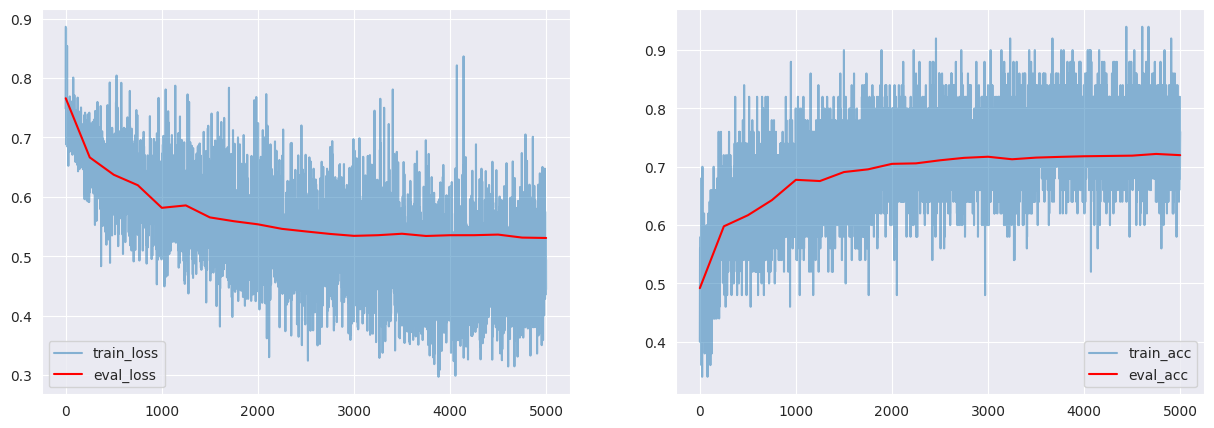

CPU times: user 54min 1s, sys: 8.97 s, total: 54min 10s
Wall time: 54min 10s


In [24]:
%%time
training_loop_fn(model, optimizer, n_epochs, 250, train_loader, test_loader)

In [25]:
val_loss, val_acc = evaluate(model, test_loader)
print(f'val loss: {val_loss}')
print(f'val accuracy: {val_acc}')

val loss: 0.530903905758287
val accuracy: 0.71992027759552


In [26]:
torch.save(model.state_dict(), '/kaggle/working/model_3')

## PEFT

In [30]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, inference_mode=False, r=8, lora_dropout=0.1, target_modules=['c_attn']
)

model = Model(tokenizer, num_classes).to(device)
lora_model = get_peft_model(model, peft_config).to(device)
lora_model.print_trainable_parameters()

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at ai-forever/rugpt3small_based_on_gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 296,448 || all params: 125,524,992 || trainable%: 0.23616651574851324


/opt/conda/lib/python3.10/site-packages/peft/tuners/lora/layer.py:711: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [31]:
sum(p.numel() for p in lora_model.parameters() if p.requires_grad)

296448

In [32]:
optimizer = AdamW(lora_model.parameters(), lr=4e-5)

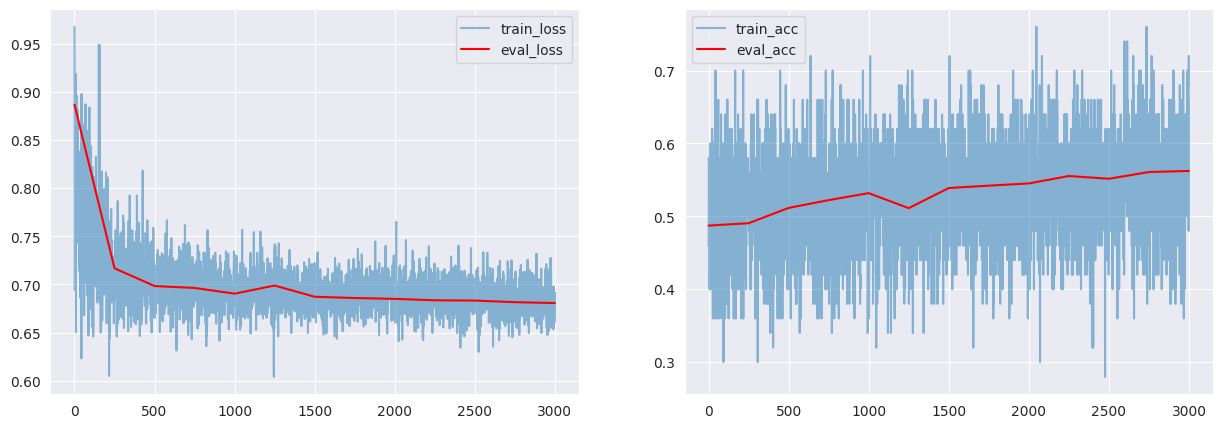

CPU times: user 27min 54s, sys: 4.96 s, total: 27min 59s
Wall time: 27min 59s


In [33]:
%%time
training_loop_fn(lora_model, optimizer, 3000, 250, train_loader, test_loader)

In [34]:
torch.save(lora_model.base_model.model.model.score.state_dict(), 'lora_head.pt')

In [35]:
chkpt = torch.load('lora_head.pt')
chkpt.keys()

odict_keys(['original_module.weight', 'modules_to_save.default.weight'])

In [36]:
model = Model(tokenizer, num_classes).to(device)
model.model.score.load_state_dict({
    'weight': torch.load('lora_head.pt')['modules_to_save.default.weight']
})
optimizer = AdamW(model.parameters(), lr=4e-5)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at ai-forever/rugpt3small_based_on_gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


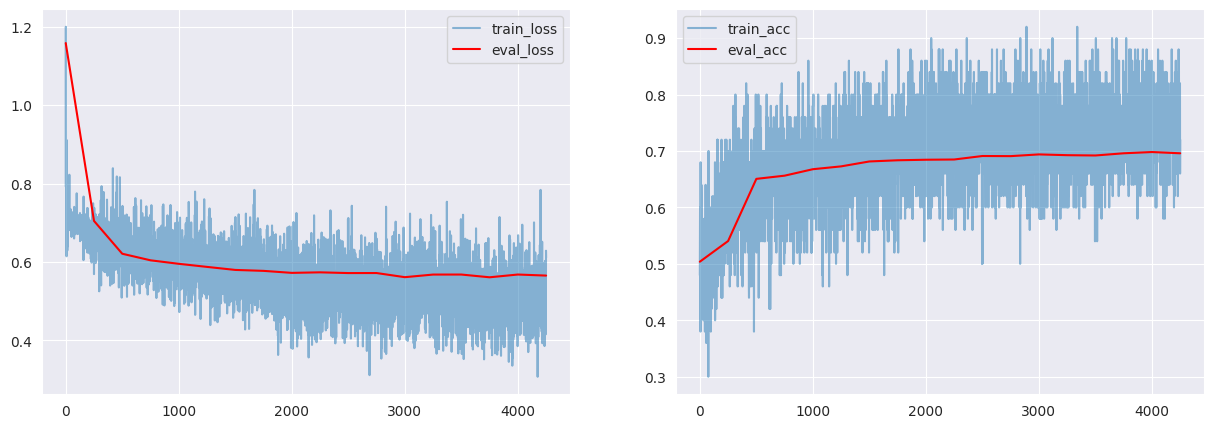

CPU times: user 46min 6s, sys: 7.61 s, total: 46min 14s
Wall time: 46min 34s


In [37]:
%%time
training_loop_fn(model, optimizer, 4250, 250, train_loader, test_loader)

In [38]:
val_loss, val_acc = evaluate(model, test_loader)
print(f'val loss: {val_loss}')
print(f'val accuracy: {val_acc}')

val loss: 0.5655068761965016
val accuracy: 0.6958984732627869
